In [1]:
import os
import random
import time
from typing import Tuple, Iterator

from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B0
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

from config import Config
import common
import custom

2024-08-09 22:44:43.404584: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 22:44:43.404679: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 22:44:43.445798: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 22:44:43.538765: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-09 22:44:44.700089: W tensorflow/compiler/tf2

In [2]:
model = custom.models.SiameseModel()
model.load_weights("checkpoints/ckpt_71")

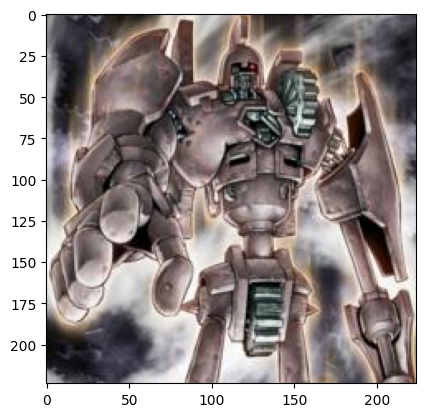

In [6]:
data1 = common.load_image_to_tensor("dataset/card_images_cropped_224/83104731.jpg")
plt.imshow(np.array(data1.numpy(), dtype=np.uint8))
data1 = common.preprocessing(data1)

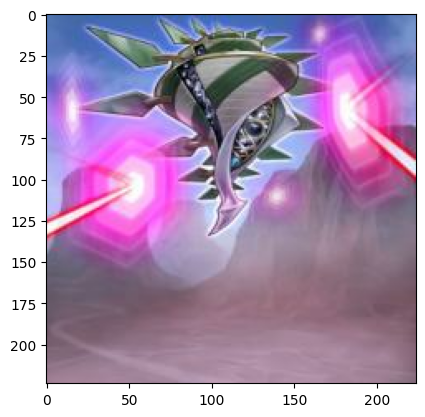

In [7]:
data2 = common.load_image_to_tensor("dataset/card_images_cropped_224/90885155.jpg")
plt.imshow(np.array(data2, dtype=np.uint8))
data2 = common.preprocessing(data2)

In [22]:
from tensorflow.keras import layers, models

light_augmentation = models.Sequential(
    [
        layers.Rescaling(255),
        layers.Resizing(Config.IMAGE_SHAPE[0], Config.IMAGE_SHAPE[1]),
        custom.augment.RandomZoominAndOut((0.2, 1)),
        layers.RandomTranslation((-0.1, 0.1), (-0.1, 0.1)),
        layers.Rescaling(1.0 / 255),
    ]
)


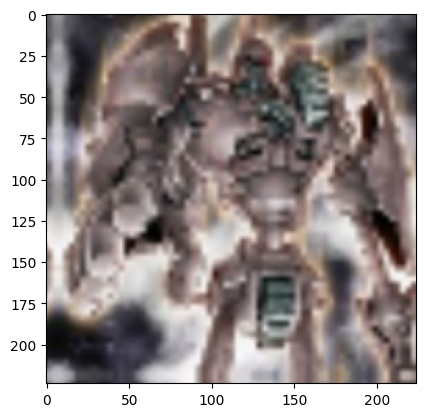

In [24]:
data4 = light_augmentation(data1)
plt.imshow(np.array(data4 * 255, dtype=np.uint8))

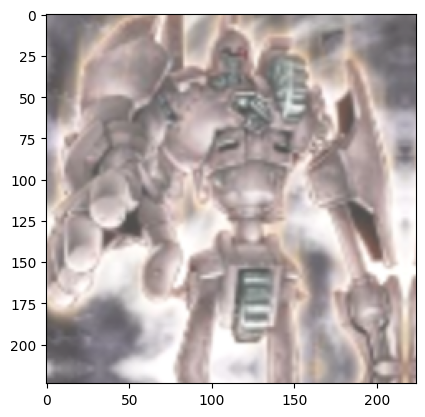

In [8]:
data3 = common.augmentation(data1)
plt.imshow(np.array(data3 * 255, dtype=np.uint8))

In [25]:
pred1 = model(tf.expand_dims(data1, axis=0))
pred2 = model(tf.expand_dims(data2, axis=0))
pred3 = model(tf.expand_dims(data3, axis=0))
pred4 = model(tf.expand_dims(data4, axis=0))

In [10]:
custom.losses.triplet_loss(pred1, pred3, pred2)

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>

In [26]:
distance = tf.math.reduce_sum(tf.math.square(pred1 - pred4), axis=-1)
distance

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.8673612], dtype=float32)>

In [12]:
distance = tf.math.reduce_sum(tf.math.square(pred1 - pred3), axis=-1)
distance

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([14.579287], dtype=float32)>

In [13]:
distance = tf.math.reduce_sum(tf.math.square(pred2 - pred3), axis=-1)
distance

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([23.908615], dtype=float32)>

In [15]:
image_path = common.extract_images(f"dataset/{Config.IMAGE_PATH}")
id_list = list(map(common.get_filename, image_path))

dataset = tf.data.Dataset.from_tensor_slices(image_path)
dataset = dataset.map(common.load_image_to_tensor, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.map(common.preprocessing, num_parallel_calls=tf.data.AUTOTUNE)

In [16]:
matrix = []
for data in dataset.batch(32):
    pred = model(data)
    matrix.append(pred)
matrix = tf.concat(matrix, axis=0)

In [17]:
matrix.shape

TensorShape([13126, 256])

In [18]:
custom.losses.square_norm(pred1, pred3)

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([14.579287], dtype=float32)>

In [19]:
custom.losses.square_norm(pred1, pred2)

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([23.625607], dtype=float32)>

In [20]:
result = tf.math.reduce_sum(tf.math.square(matrix - pred3), axis=-1)
result = result.numpy()
argsort = np.argsort(result)

In [21]:
for index in argsort[:1000]:
    print(image_path[index], result[index])

dataset/card_images_cropped/66194206.jpg 0.70576036
dataset/card_images_cropped/8837932.jpg 0.74655277
dataset/card_images_cropped/29981921.jpg 0.8736262
dataset/card_images_cropped/30100551.jpg 0.96202725
dataset/card_images_cropped/22201234.jpg 1.1097574
dataset/card_images_cropped/81816475.jpg 1.1650534
dataset/card_images_cropped/93187568.jpg 1.176508
dataset/card_images_cropped/92736188.jpg 1.2025208
dataset/card_images_cropped/8321183.jpg 1.2052115
dataset/card_images_cropped/64927055.jpg 1.2601899
dataset/card_images_cropped/82315403.jpg 1.3131915
dataset/card_images_cropped/48608796.jpg 1.419179
dataset/card_images_cropped/4545683.jpg 1.4566722
dataset/card_images_cropped/79791878.jpg 1.4840775
dataset/card_images_cropped/78364470.jpg 1.591213
dataset/card_images_cropped/56196385.jpg 1.5927821
dataset/card_images_cropped/78917791.jpg 1.6109962
dataset/card_images_cropped/16269385.jpg 1.6303065
dataset/card_images_cropped/87836938.jpg 1.6543133
dataset/card_images_cropped/172170